In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('DEBUG')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)
seaborn.set_palette('colorblind')
import os

In [7]:
# Previously trained model
load_folder = '/data//schirrmr/schirrmr/reversible-icml/models/mnist/OptimalTransportPerClassClampedStd/2599/'

In [4]:
import itertools
from reversible.plot import create_bw_image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

In [8]:
from reversible.util import set_random_seeds
from reversible.revnet import init_model_params
import torch as th
from reversible.models import create_MNIST_model
th.backends.cudnn.benchmark = True
set_random_seeds(34093049, True)
feature_model = create_MNIST_model()

feature_model = feature_model.cuda()

n_dims = 1024

import torch as th
means_per_cluster = th.load(load_folder + '/means.pkl')

stds_per_cluster = th.load(load_folder + '/stds.pkl')
feature_model.load_state_dict(th.load(load_folder + '/model_dict.pkl'))

## Samples

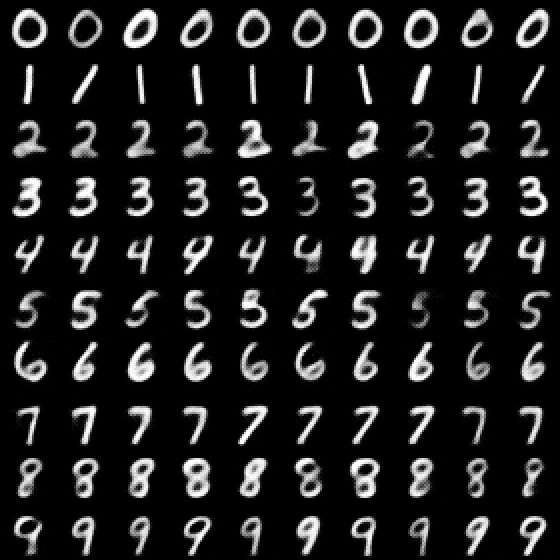

In [28]:
from reversible.gaussian import get_gauss_samples
from reversible.revnet import invert
from reversible.util import np_to_var, var_to_np
set_random_seeds(20180801, True)
all_examples = []
for i_class in range(len(means_per_cluster)):
    samples = get_gauss_samples(10, means_per_cluster[i_class], stds_per_cluster[i_class],)
    inverted = var_to_np(invert(feature_model, samples)).astype(np.float64)
    all_examples.append(inverted)
all_examples = np.concatenate(all_examples)

all_examples = all_examples.reshape(10,10,28,28)

im = create_bw_image(1 - all_examples).resize((20*28,20*28))

display(im)

## Varying latent dimensions

Results somewhat different from paper

In [46]:
global_std = th.mean(th.stack(stds_per_cluster, dim=0), dim=0)

i_std_1, i_std_2, i_std_3,i_std_4 = np.argsort(var_to_np(global_std))[::-1][:4]

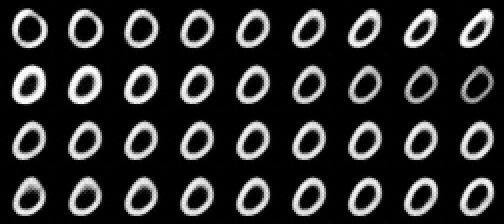

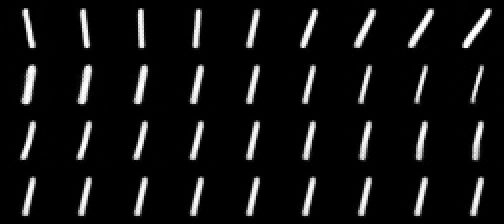

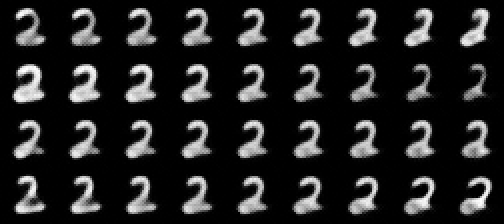

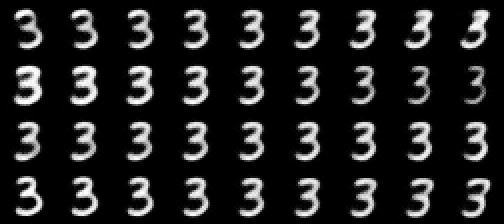

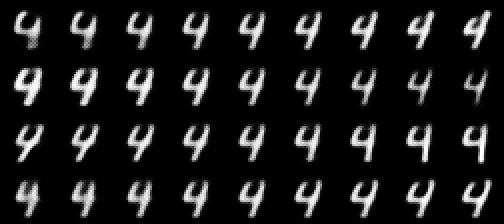

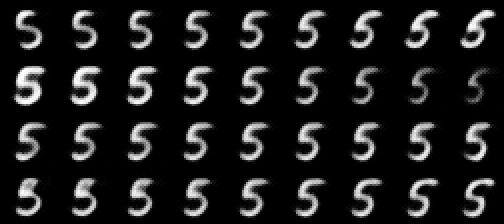

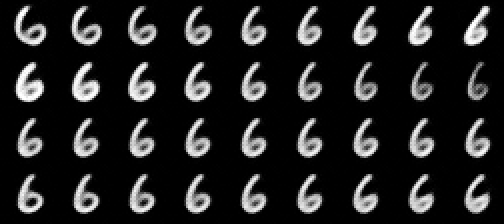

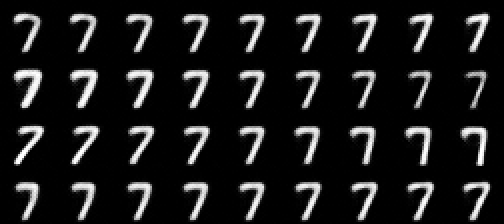

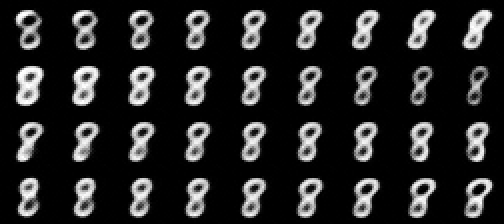

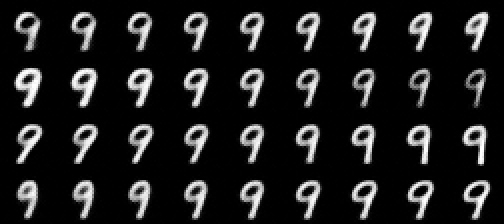

In [48]:
n_examples_per_dim = 9
for i_cluster in range(len(means_per_cluster)):
    image_grid = np.zeros((4, n_examples_per_dim, 28,28))
    for i_i_std, i_feature_a in enumerate([i_std_1, i_std_2, i_std_3,i_std_4]):
        mean = means_per_cluster[i_cluster]
        std = stds_per_cluster[i_cluster]
        feature_a_values = th.linspace(float(mean[i_feature_a].data - 2 * std[i_feature_a].data),
                                       float(mean[i_feature_a].data + 2 * std[i_feature_a].data),
                                      n_examples_per_dim)

    

        for i_f_a_val, f_a_val in enumerate(feature_a_values):
            this_out = mean.clone()
            this_out.data[i_feature_a] = f_a_val
            inverted = var_to_np(invert(feature_model, this_out.unsqueeze(0))[0]).squeeze()
            image_grid[i_i_std, i_f_a_val] = np.copy(inverted)
    im = create_bw_image(1-image_grid).resize((9*2*28,4*2*28))
    display(im)